In [1]:
import sys
from typing import Any

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.axes import Axes
from matplotlib.colors import Normalize
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
from numba import njit

sys.path.append("..")
from NGS.data import preprocess
from path import DATA_DIR, RESULT_DIR

plt.rcParams.update(
    {
        "font.family": "FreeSerif",
        "mathtext.default": "regular",
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
        "font.size": 20,
        "axes.titlesize": 20,
        "axes.labelsize": 20,
        "legend.fontsize": 20,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
    }
)

thresholds = [2, 3, 4, 6]   # pi/2, pi/3, pi/4, pi/6

In [2]:
# True data
df = pd.read_pickle(DATA_DIR / "kuramoto_train.pkl")
_, val = preprocess(df, 0.2)
eval_times = [np.insert(np.cumsum(dt), 0, 0.0) for dt in val["dts"]]
true_trajectories = [traj.squeeze() for traj in val["trajectories"]]


# LSODA Approximation, NGS predictions
approx_trajectories = {}
approx_errors = {}
approx_nfevs = {}
approx_runtimes = {}

pred_trajectories = {}
pred_nfevs = {}
pred_runtimes = {}
pred_errors = {}


for threshold in thresholds:
    # LSODA
    df = pd.read_pickle(DATA_DIR / f"kuramoto_train_{threshold}.pkl")
    approx_trajectories[threshold] = df["trajectories"].tolist()
    approx_nfevs[threshold] = df["nfevs"].values
    approx_runtimes[threshold] = df["runtimes"].values
    approx_errors[threshold] = [
        approx_traj - true_traj
        for approx_traj, true_traj in zip(
            approx_trajectories[threshold], true_trajectories
        )
    ]

    # NGS
    exp_id = f"kuramoto_th{threshold}"
    result_dir = RESULT_DIR / exp_id
    pred_df = pd.read_pickle(result_dir / "kuramoto_train.pkl")
    pred_trajectories[threshold] = [
        traj.squeeze() for traj in pred_df["trajectories"].tolist()[-200:]
    ]
    pred_nfevs[threshold] = pred_df["nfev"].values
    pred_runtimes[threshold] = pred_df["runtime"].values

    pred_errors[threshold] = [
        pred_traj - true_traj
        for pred_traj, true_traj in zip(
            pred_trajectories[threshold], true_trajectories
        )
    ]

### Single sample

In [3]:
sample_idx = 141
threshold = 6

true_trajectory = true_trajectories[sample_idx]
approx_trajectory = approx_trajectories[threshold][sample_idx]
pred_trajectory = pred_trajectories[threshold][sample_idx]
approx_error = approx_errors[threshold][sample_idx]
pred_error = pred_errors[threshold][sample_idx]
eval_time = eval_times[sample_idx]
num_nodes = true_trajectory.shape[1]

true_cmap, true_vmin, true_vmax = "twilight_shifted", -np.pi, np.pi
error_cmap, error_vmin, error_vmax = "RdYlGn", -np.pi / 20, np.pi / 20
true_kwargs = dict(cmap=true_cmap, vmin=true_vmin, vmax=true_vmax)
error_kwargs: dict[str, Any] = dict(cmap=error_cmap, vmin=error_vmin, vmax=error_vmax)


@njit
def get_adjacency(phase: np.ndarray, threshold: float) -> np.ndarray:
    """phase: [N, ]"""
    if threshold >= np.pi / 2:
        adjacency = np.ones((len(phase), len(phase)), dtype=np.float64)
        np.fill_diagonal(adjacency, 0.0)
        return adjacency

    phase = phase[:, None] % (2.0 * np.pi)  # [N, 1] in the range of [0, 2pi]
    phase_diff = np.abs(phase - phase.T)  # [N, N] in the range of [0, 2pi]

    adjacency = (np.abs(phase_diff - 0.5 * np.pi) < threshold) + (
        np.abs(phase_diff - 1.5 * np.pi) < threshold
    )
    adjacency = adjacency & ~np.eye(len(adjacency), dtype=np.bool_)
    return adjacency.astype(np.float64)


def normalize_phase(phase: np.ndarray) -> np.ndarray:
    return (phase + np.pi) % (2 * np.pi) - np.pi


def plot_state_graph(ax: Axes, state: np.ndarray, threshold: float, **kwargs) -> None:
    adjacency = get_adjacency(state, threshold)
    graph = nx.from_numpy_array(adjacency)
    pos = {i: np.array([np.cos(phase), np.sin(phase)]) for i, phase in enumerate(state)}
    nx.draw_networkx_nodes(
        graph, pos=pos, ax=ax, node_size=80, linewidths=0.4, edgecolors="k", **kwargs
    )
    nx.draw_networkx_edges(graph, pos=pos, ax=ax, width=0.02)


def plot_state_2d(ax: Axes, error: np.ndarray) -> None:
    num_nodes = error.shape[1]
    ax.pcolormesh(eval_time, np.arange(num_nodes + 1), error[1:].T, **error_kwargs)


def shrink_cbar(cax, shrink: float):
    b = cax.get_position()
    pad = 0.5 * (1.0 - shrink) * b.height
    b.y0 += pad
    b.y1 -= pad
    cax.set_position(b)


def plot_cbar(
    fig: Figure, cax: Axes, vmin: float, vmax: float, cmap: str, shrink: float = 0.8
) -> None:
    sm = cm.ScalarMappable(Normalize(vmin, vmax), cmap)
    fig.colorbar(sm, cax=cax, location="right")
    shrink_cbar(cax, shrink)

### MAE

In [4]:
bar_width = 0.1
ngs_locations = np.array([0.05, 0.30, 0.55, 0.8])
lsoda_locations = ngs_locations + bar_width
bar_kwargs = {"width": bar_width, "capsize": 5, "align": "edge"}
def plot_mae(ax: Axes) -> None:

    pred_avg, pred_ci = [], []
    approx_avg, approx_ci = [], []
    for threshold in thresholds:
        approx_mae = np.array([
            np.abs(error).mean() for error in approx_errors[threshold]
        ])
        approx_avg.append(approx_mae.mean())
        approx_ci.append(1.96 * approx_mae.std() / np.sqrt(len(approx_mae)))

        # threshold = 6
        pred_mae = np.array([
            np.abs(error).mean() for error in pred_errors[threshold]
        ])
        pred_avg.append(pred_mae.mean())
        pred_ci.append(1.96 * pred_mae.std() / np.sqrt(len(pred_mae)))

    ax.bar(
        ngs_locations, pred_avg, yerr=pred_ci, color="#48A9A6", label="NGS", **bar_kwargs
    )
    ax.bar(
        lsoda_locations[1:],
        approx_avg[1:],
        yerr=approx_ci[1:],
        color="#FBE137",
        label="LSODA",
        **bar_kwargs,
    )

# Error mesh
def add_patch(ax: Axes, step: int) -> None:
    ax.add_patch(
        patches.Rectangle(
            xy=(eval_time[step - 1], 1),
            width=eval_time[step] - eval_time[step - 1],
            height=num_nodes - 1.5,
            edgecolor="blue",
            fill=False,
            linewidth=2.0,
        )
    )

### Efficiency

In [5]:
def plot_efficiency(
    ax: Axes,
    pred: dict[int, np.ndarray],
    approx: dict[int, np.ndarray],
    colors: tuple[str, str],
) -> None:
    pred_avg, pred_ci = [], []
    approx_avg, approx_ci = [], []

    for threshold in thresholds:
        num_samples = len(approx[threshold])
        approx_avg.append(approx[threshold].mean())
        approx_ci.append(1.96 * approx[threshold].std() / np.sqrt(num_samples))

        # threshold = 6
        pred_avg.append(pred[threshold].mean())
        pred_ci.append(1.96 * pred[threshold].std() / np.sqrt(num_samples))

    if all(ci == 0.0 for ci in pred_ci):
        pred_ci = None

    ax.bar(
        ngs_locations,
        pred_avg,
        yerr=pred_ci,
        color=colors[0],
        label="NGS",
        **bar_kwargs
    )
    ax.bar(
        lsoda_locations,
        approx_avg,
        yerr=approx_ci,
        color=colors[1],
        label="LSODA",
        **bar_kwargs
    )
    ax.set_yscale("log")

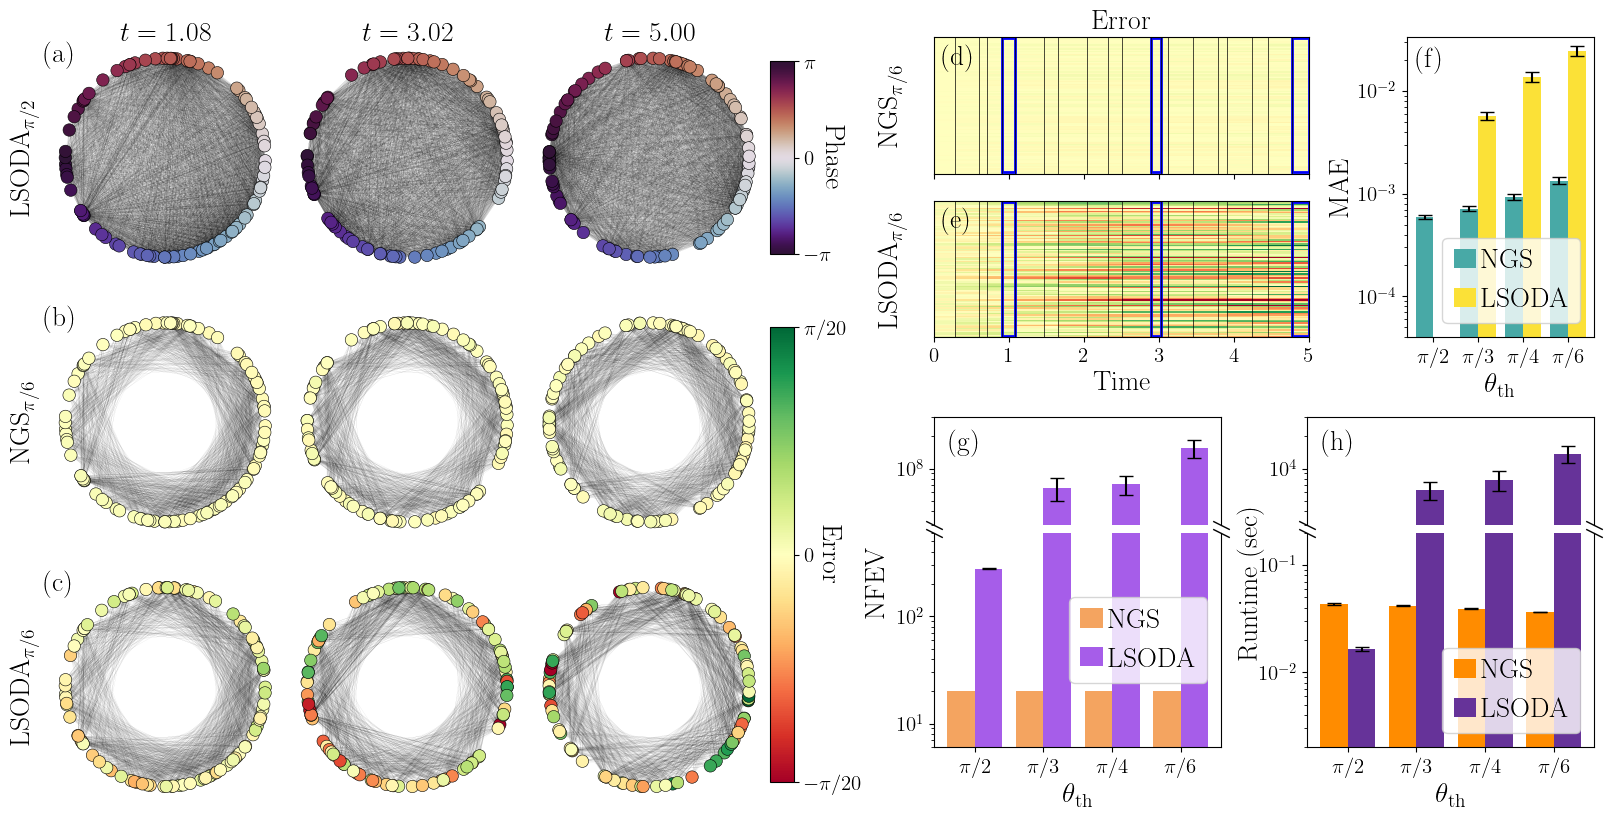

In [6]:
fig = plt.figure(figsize=(20, 10))
gs1 = GridSpec(
    nrows=3, ncols=4, hspace=0.1, wspace=0.0, right=0.5, width_ratios=[1, 1, 1, 0.1]
)
gs2 = GridSpec(
    2, 2, hspace=0.2, wspace=0.35, left=0.57, bottom=0.58, width_ratios=[2, 1]
)
gs3 = GridSpec(
    2,
    2,
    left=0.57,
    top=0.50,
    bottom=0.17,
    hspace=0.05,
    wspace=0.3,
    height_ratios=[1, 2],
)

ax1 = fig.add_subplot(gs1[0, 0], frameon=False)
ax2 = fig.add_subplot(gs1[0, 1], frameon=False)
ax3 = fig.add_subplot(gs1[0, 2], frameon=False)
ax4 = fig.add_subplot(gs1[1, 0], frameon=False)
ax5 = fig.add_subplot(gs1[1, 1], frameon=False)
ax6 = fig.add_subplot(gs1[1, 2], frameon=False)
ax7 = fig.add_subplot(gs1[2, 0], frameon=False)
ax8 = fig.add_subplot(gs1[2, 1], frameon=False)
ax9 = fig.add_subplot(gs1[2, 2], frameon=False)
cax1 = fig.add_subplot(gs1[0, 3])
cax2 = fig.add_subplot(gs1[1:3, 3])

ax10 = fig.add_subplot(gs2[0, 0])
ax11 = fig.add_subplot(gs2[1, 0])
ax12 = fig.add_subplot(gs2[:, 1])
ax13 = fig.add_subplot(gs3[0, 0])
ax14 = fig.add_subplot(gs3[0, 1])
ax15 = fig.add_subplot(gs3[1, 0])
ax16 = fig.add_subplot(gs3[1, 1])
ax13.spines.bottom.set_visible(False)
ax14.spines.bottom.set_visible(False)
ax15.spines.top.set_visible(False)
ax16.spines.top.set_visible(False)
d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs: dict[str, Any] = dict(
    marker=[(-1, d), (1, -d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
ax13.plot([0, 1], [0, 0], transform=ax13.transAxes, **kwargs)
ax15.plot([0, 1], [1, 1], transform=ax15.transAxes, **kwargs)
ax14.plot([0, 1], [0, 0], transform=ax14.transAxes, **kwargs)
ax16.plot([0, 1], [1, 1], transform=ax16.transAxes, **kwargs)

steps = [5, 12, 20]

# True state
for ax, step in zip([ax1, ax2, ax3], steps):
    state = normalize_phase(true_trajectory[step])
    plot_state_graph(ax, state, np.pi / 2.0, node_color=state, **true_kwargs)

# Errors
for ax, step in zip([ax4, ax5, ax6], steps):
    state = normalize_phase(pred_trajectory[step])
    error = pred_error[step]
    plot_state_graph(ax, state, np.pi / threshold, node_color=error, **error_kwargs)

for ax, step in zip([ax7, ax8, ax9], steps):
    state = normalize_phase(approx_trajectory[step])
    error = approx_error[step]
    plot_state_graph(ax, state, np.pi / threshold, node_color=error, **error_kwargs)

# Color bars
plot_cbar(fig, cax1, true_vmin, true_vmax, true_cmap, 0.8)
plot_cbar(fig, cax2, error_vmin, error_vmax, error_cmap, 0.9)

# Errors
for ax, error in zip([ax10, ax11], [pred_error, approx_error]):
    plot_state_2d(ax, error)
    for t in eval_time[1:]:
        ax.axvline(t, color="k", linewidth=0.5)
    for step in steps:
        add_patch(ax, step)

# MAE
plot_mae(ax12)
ax12.set_yscale("log")

# Efficiency
plot_efficiency(ax13, pred_nfevs, approx_nfevs, ("sandybrown", "#A65DE9"))
plot_efficiency(ax14, pred_runtimes, approx_runtimes, ("darkorange", "rebeccapurple"))
plot_efficiency(ax15, pred_nfevs, approx_nfevs, ("sandybrown", "#A65DE9"))
plot_efficiency(ax16, pred_runtimes, approx_runtimes, ("darkorange", "rebeccapurple"))

# limits
ax12.set_ylim(4e-5, None)
ax13.set_ylim(3e7, 3e8)
ax14.set_ylim(3e3, 3e4)
ax15.set_ylim(6e0, 6e2)
ax16.set_ylim(2e-3, 2e-1)

# Title
for ax, step in zip([ax1, ax2, ax3], steps):
    ax.set_title("$t=" + f"{eval_times[sample_idx][step]:.2f}" + "$", y=0.95)
ax10.set_title("Error")

# Legend
ax12.legend(
    handlelength=0.8,
    handletextpad=0.2,
    loc="lower right",
)
ax15.legend(handlelength=0.8, handletextpad=0.2, loc="center right")
ax16.legend(handlelength=0.8, handletextpad=0.2, loc="lower right")


# Ticks
cax1.set_yticks([-np.pi, 0, np.pi], [r"$-\pi$", r"$0$", r"$\pi$"])
cax2.set_yticks([-np.pi / 20, 0, np.pi / 20], [r"$-\pi/20$", r"$0$", r"$\pi/20$"])
ax10.set_xticklabels([])
ax10.set_yticks([])
ax11.set_yticks([])
ax13.set_xticks([])
ax13.set_yticks([3e7, 4e7, 5e7, 6e7, 7e7, 8e7, 9e7, 2e8, 3e8], labels=[], minor=True)
ax14.set_xticks([])
ax14.set_yticks([3e3, 4e3, 5e3, 6e3, 7e3, 8e3, 9e3, 2e4, 3e4], labels=[], minor=True)
for ax in [ax12, ax15, ax16]:
    ax.set_xticks(lsoda_locations, [r"$\pi/2$", r"$\pi/3$", r"$\pi/4$", r"$\pi/6$"])

# Labels
ax1.set_ylabel("LSODA" + r"${}_{\pi/2}$")
ax4.set_ylabel("NGS" + r"${}_{\pi/6}$")
ax7.set_ylabel("LSODA" + r"${}_{\pi/6}$")
cax1.set_ylabel("Phase", rotation=-90, labelpad=10)
cax2.set_ylabel("Error", rotation=-90, labelpad=-15)
ax10.set_ylabel("NGS" + r"${}_{\pi/6}$", labelpad=20)
ax11.set_ylabel("LSODA" + r"${}_{\pi/6}$", labelpad=20)
ax11.set_xlabel("Time")
ax12.set_ylabel("MAE")
for ax in [ax12, ax15, ax16]:
    ax.set_xlabel(r"$\theta_\text{th}$")
ax_ghost1 = fig.add_subplot(gs3[:, 0], frameon=False)
ax_ghost1.axis("off")
ax_ghost1.text(-0.2, 0.5, "NFEV", rotation=90, ha="center", va="center")
ax_ghost2 = fig.add_subplot(gs3[:, 1], frameon=False)
ax_ghost2.axis("off")
ax_ghost2.text(-0.2, 0.5, "Runtime (sec)", rotation=90, ha="center", va="center")

# Texts
ax1.text(0.0, 0.9, "(a)", transform=ax1.transAxes)
ax4.text(0.0, 0.9, "(b)", transform=ax4.transAxes)
ax7.text(0.0, 0.9, "(c)", transform=ax7.transAxes)
ax10.text(0.02, 0.80, "(d)", transform=ax10.transAxes)
ax11.text(0.02, 0.80, "(e)", transform=ax11.transAxes)
ax12.text(0.05, 0.90, "(f)", transform=ax12.transAxes)
ax13.text(0.05, 0.70, "(g)", transform=ax13.transAxes)
ax14.text(0.05, 0.70, "(h)", transform=ax14.transAxes)

# fig.savefig("fig4.png", bbox_inches="tight")
fig.show()